In [51]:
# This notebook is for yeo 7 networks calculation based on the gradient-weighted cortical maps.

# Includes:
#    loding cortical surface data
#    saving cortical surface data to dataframe and csv
#    loading network txt
#    displaying cortical gradient network histogram
#    statistical test on networks mean differences

In [1]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from brainspace.datasets import load_fsa5, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from statannotations.Annotator import Annotator
import pingouin as pg

### Setting the path

In [2]:
# Set this to your git-repo path for running the analyses.
main_path = "/srv/khan/users/sudesnac/00_Projects/HumanBF-Connectivity"

In [3]:
# Setting other paths
data_path = main_path + "/data/"
results_path = main_path + "/results/g-wCtx_networks/"
fig_path = main_path + "/results/g-wCtx_networks/figures/"

In [4]:
Func_results = main_path + "/results/Func_gradients/"
Diff_results = main_path + "/results/Diff_gradients/"

### Loading gradient weighted cortical connectivity data

In [5]:
Func_GCtx = np.load(Func_results + 'Func_Gradient-weighted_CorticalConnectivity.npz')
Func_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx']

In [6]:
Diff_GCtx = np.load(Diff_results + 'Diff_Gradient-weighted_CorticalConnectivity.npz')
Diff_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G5_Ctx', 'G6_Ctx']

### Network coloring and surface projection

#### Yeo network from brainstat

In [7]:
from matplotlib.colors import ListedColormap
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.datasets import fetch_parcellation
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainstat.datasets import fetch_yeo_networks_metadata

surfaces = fetch_template_surface("fsaverage5", join=False)
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)
#yeo_colormap_gray = np.concatenate((np.array([[0.7, 0.7, 0.7]]), yeo_colormap))
yeoCols = ListedColormap(yeo_colormap, name='yeo_colormap')

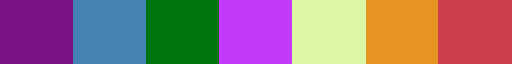

In [8]:
yeoCols

/tmp/ipykernel_59791/1878058114.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


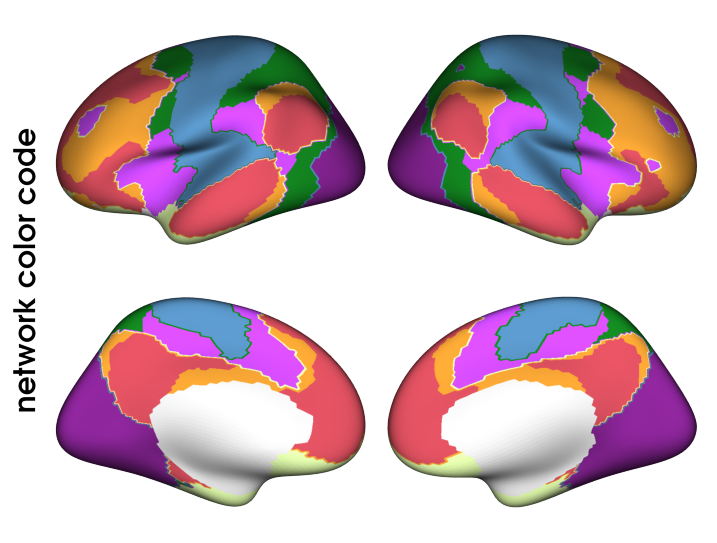

In [9]:
# Visualize
# plot both BF and geodic distance together
from neuromaps.datasets import fetch_fsaverage
from surfplot import Plot

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), label_text={'left':['network color code']}, brightness=.8)
p.add_layer(yeo_networks, cmap=yeoCols, cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'Yeo_7_Networks_inflated_surface_grid.png', dpi=300, bbox_inches='tight')

### Calculating network association with cortical maps

#### Yeo 7 Network data

In [10]:
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)

In [11]:
labels_txt

,0
0,1_R_V1_ROI_1_Visual
1,2_R_MST_ROI_1_Visual
2,3_R_V6_ROI_1_Visual
3,4_R_V2_ROI_1_Visual
4,5_R_V3_ROI_1_Visual
...,...
355,356_L_STSva_ROI_7_Default
356,357_L_TE1m_ROI_7_Default
357,358_L_PI_ROI_4_Ventral Attention
358,359_L_a32pr_ROI_6_Frontoparietal


In [12]:
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()
num_network = labels_txt['Network#'].unique()

In [13]:
num_network

array(['1', '2', '3', '4', '7', '6', '5'], dtype=object)

#### Functional data

In [16]:
# getting cortical data
Func_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx']

In [17]:
func_g1 = pd.DataFrame(Func_GCtx['G1_Ctx'])
func_g2 = pd.DataFrame(Func_GCtx['G2_Ctx'])

In [18]:
net_mean = []
funcG1_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = func_g1.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    funcG1_net[str(nets)] = pd.Series(net_mean.values)

In [19]:
net_mean = []
funcG2_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = func_g2.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    funcG2_net[str(nets)] = pd.Series(net_mean.values)

In [20]:
# Saving network data
pd.DataFrame(funcG1_net).to_csv(results_path + 'Func_G1-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(funcG2_net).to_csv(results_path + 'Func_G2-Gradient-weighted_cortical_networks.csv', index=False)

#### Structural data

In [21]:
# getting srtuctural cortical data
Diff_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G5_Ctx', 'G6_Ctx']

In [22]:
diff_g1 = pd.DataFrame(Diff_GCtx['G1_Ctx'])
diff_g2 = pd.DataFrame(Diff_GCtx['G2_Ctx'])

In [23]:
net_mean = []
diffG1_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g1.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG1_net[str(nets)] = pd.Series(net_mean.values)

In [24]:
net_mean = []
diffG2_net = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con_df = diff_g2.iloc[:,net_inds]
    net_mean = net_con_df.mean()
    diffG2_net[str(nets)] = pd.Series(net_mean.values)

In [25]:
# Saving network data
pd.DataFrame(diffG1_net).to_csv(results_path + 'Diff_G1-Gradient-weighted_cortical_networks.csv', index=False)
pd.DataFrame(diffG2_net).to_csv(results_path + 'Diff_G2-Gradient-weighted_cortical_networks.csv', index=False)

### Loading the cortical network data from saved csv

In [14]:
# getting cortical network datas for graphs
funcG1_net = pd.read_csv(results_path + 'Func_G1-Gradient-weighted_cortical_networks.csv')
funcG2_net = pd.read_csv(results_path + 'Func_G2-Gradient-weighted_cortical_networks.csv')

In [15]:
# getting cortical network datas for graphs
diffG1_net = pd.read_csv(results_path + 'Diff_G1-Gradient-weighted_cortical_networks.csv')
diffG2_net = pd.read_csv(results_path + 'Diff_G2-Gradient-weighted_cortical_networks.csv')

### Plot with sns: kdeplots and histplots

#### Gradient 1 bar plot

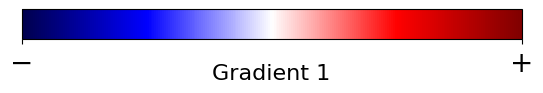

In [28]:
fig = plt.figure(figsize=(10,10))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
#plt.savefig(fig_path+f'Gradient1_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Setting the color for 7 networks
yeo_cols = {"Visual":yeoCols.colors[0,:], "Somatomotor":yeoCols.colors[1,:], "Dorsal Attention":yeoCols.colors[2,:], "Ventral Attention":yeoCols.colors[3,:], "Default":yeoCols.colors[6,:], "Frontoparietal":yeoCols.colors[5,:], "Limbic":yeoCols.colors[4,:]}

#### Functional Data

##### Data DFs

In [17]:
funcG1_net.head(5)

,Visual,Somatomotor,Dorsal Attention,Ventral Attention,Default,Frontoparietal,Limbic
0,0.012430,0.002987,0.023383,0.005559,-0.005389,-0.004487,-0.016521
1,0.007695,-0.000472,0.023702,0.009877,-0.003734,-0.005268,-0.003320
2,0.009775,0.011242,0.000753,0.010916,-0.024482,0.004495,0.011127
3,0.007877,-0.002156,0.013131,0.016987,-0.021805,-0.013583,-0.000890
4,0.007958,0.001817,0.015157,0.019695,-0.011862,-0.001811,0.009489


In [18]:
sort_funcG1 = funcG1_net.mean().sort_values().index
sorted_funcG1 = funcG1_net[sort_funcG1]
sorted_funcG1.head(5)

,Default,Limbic,Visual,Somatomotor,Frontoparietal,Dorsal Attention,Ventral Attention
0,-0.005389,-0.016521,0.012430,0.002987,-0.004487,0.023383,0.005559
1,-0.003734,-0.003320,0.007695,-0.000472,-0.005268,0.023702,0.009877
2,-0.024482,0.011127,0.009775,0.011242,0.004495,0.000753,0.010916
3,-0.021805,-0.000890,0.007877,-0.002156,-0.013583,0.013131,0.016987
4,-0.011862,0.009489,0.007958,0.001817,-0.001811,0.015157,0.019695


In [19]:
funcG1_melt_net = pd.melt(funcG1_net, var_name='Networks', value_name='Gradients')
funcG1_melt_net.head(5)

,Networks,Gradients
0,Visual,0.012430
1,Visual,0.007695
2,Visual,0.009775
3,Visual,0.007877
4,Visual,0.007958


In [20]:
sorted_funcG1_melt = pd.melt(sorted_funcG1, var_name='Networks', value_name='Gradients')
sorted_funcG1_melt.head(5)

,Networks,Gradients
0,Default,-0.005389
1,Default,-0.003734
2,Default,-0.024482
3,Default,-0.021805
4,Default,-0.011862


##### KDE plots

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-p

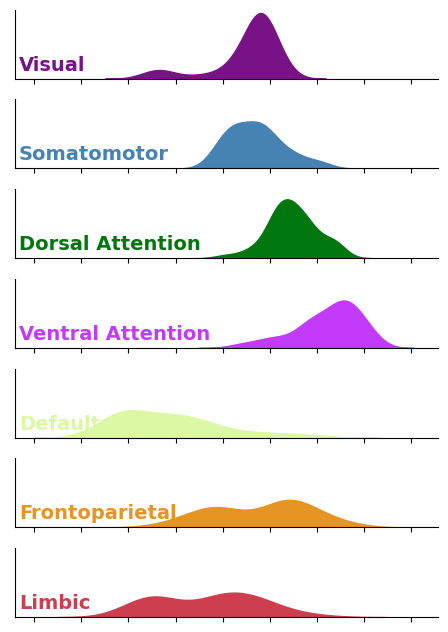

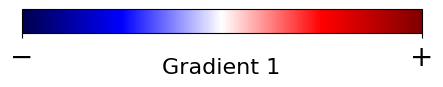

In [36]:
g = sns.FacetGrid(funcG1_melt_net, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .2, label, fontweight="bold", color=color,
            ha="left", va="center", fontsize=14, transform=ax.transAxes)
g.map(label, "Gradients")

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.3)

#g.savefig(fig_path+f'Func_G1-weighted_cortical_networks_Facet-kdes.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(8,8))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-p

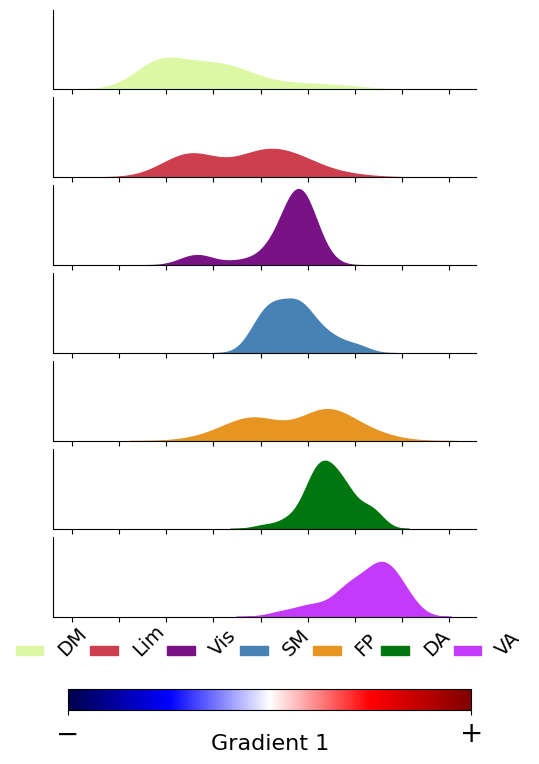

In [37]:
g = sns.FacetGrid(sorted_funcG1_melt, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)

hue_labels = ['DM','Lim','Vis','SM','FP','DA','VA']
g.add_legend(labels=hue_labels)
sns.move_legend(
    g, "center",
    bbox_to_anchor=(0.5, 0.05), ncol=7, title=None, borderaxespad=0,
    columnspacing=0
)
for text in g.legend.texts:
    text.set_fontsize(14)
    text.set_rotation(45)

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.1)

norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = g.fig.add_axes([0.15, -.05, 0.7, 0.03]) # start x, start y, length x, height y
cb = g.fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                    ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)

g.savefig(fig_path+f'Func_G1-weighted_cortical_networks_Facet-kdes_Mean-sorted_blabel.png', dpi=300, bbox_inches='tight')

##### HistPlots

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-p

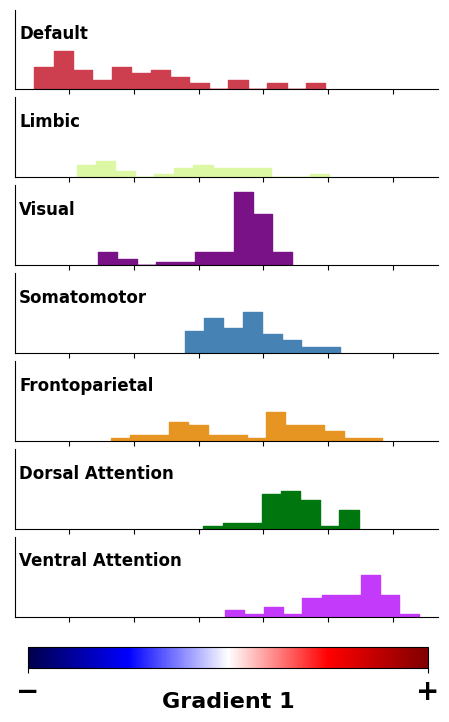

In [35]:
g = sns.FacetGrid(sorted_funcG1_melt, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.histplot,"Gradients", element="step",fill=True, alpha=1, common_bins=True, binwidth=0.003)
g.set(ylim=(0, 25))

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .7, label, fontweight="bold",
            ha="left", va="center", fontsize=12, transform=ax.transAxes)
g.map(label, "Gradients")
g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.1)

norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = g.fig.add_axes([0.15, 0.01, 0.8, 0.03]) # start x, start y, length x, height y
cb = g.fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10, fontweight="bold")
cb.ax.set_xticklabels(['−','+'], fontsize=20, fontweight="bold")

g.savefig(fig_path+f'Func_G1-weighted_cortical_networks_Facet-hist-step_Mean-sorted_color-corrected.png', dpi=300, bbox_inches='tight')

##### Data DFs

In [29]:
diffG1_net.head(5)

,Visual,Somatomotor,Dorsal Attention,Ventral Attention,Default,Frontoparietal,Limbic
0,0.096945,-0.006741,-0.023705,-0.017566,-0.023924,0.055088,-0.106317
1,0.042232,0.027682,-0.005627,0.032352,0.015262,0.075605,-0.071947
2,0.102752,0.016094,0.035422,0.029706,-0.029695,-0.016537,-0.058401
3,0.089521,0.038716,0.084221,0.049748,0.020283,-0.004884,-0.145429
4,0.103112,0.073857,0.099652,-0.049187,-0.161078,-0.002066,-0.070429


In [30]:
sort_diffG1 = diffG1_net.mean().sort_values().index
sorted_diffG1 = diffG1_net[sort_diffG1]
sorted_diffG1.head(5)

,Default,Limbic,Ventral Attention,Frontoparietal,Somatomotor,Dorsal Attention,Visual
0,-0.023924,-0.106317,-0.017566,0.055088,-0.006741,-0.023705,0.096945
1,0.015262,-0.071947,0.032352,0.075605,0.027682,-0.005627,0.042232
2,-0.029695,-0.058401,0.029706,-0.016537,0.016094,0.035422,0.102752
3,0.020283,-0.145429,0.049748,-0.004884,0.038716,0.084221,0.089521
4,-0.161078,-0.070429,-0.049187,-0.002066,0.073857,0.099652,0.103112


In [31]:
diffG1_melt_net = pd.melt(diffG1_net, var_name='Networks', value_name='Gradients')
diffG1_melt_net.head(5)

,Networks,Gradients
0,Visual,0.096945
1,Visual,0.042232
2,Visual,0.102752
3,Visual,0.089521
4,Visual,0.103112


In [32]:
sorted_diffG1_melt = pd.melt(sorted_diffG1, var_name='Networks', value_name='Gradients')
sorted_diffG1_melt.head(5)

,Networks,Gradients
0,Default,-0.023924
1,Default,0.015262
2,Default,-0.029695
3,Default,0.020283
4,Default,-0.161078


##### KDE plots

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-p

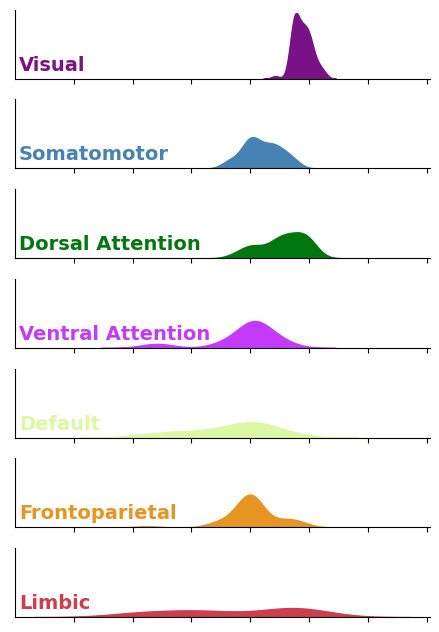

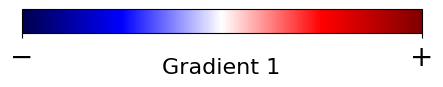

In [43]:
g = sns.FacetGrid(diffG1_melt_net, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .2, label, fontweight="bold", color=color,
            ha="left", va="center", fontsize=14, transform=ax.transAxes)
g.map(label, "Gradients")

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.3)

#g.savefig(fig_path+f'Diff_G1-weighted_cortical_networks_Facet-kdes.png', dpi=300, bbox_inches='tight')

fig = plt.figure(figsize=(8,8))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)
plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-p

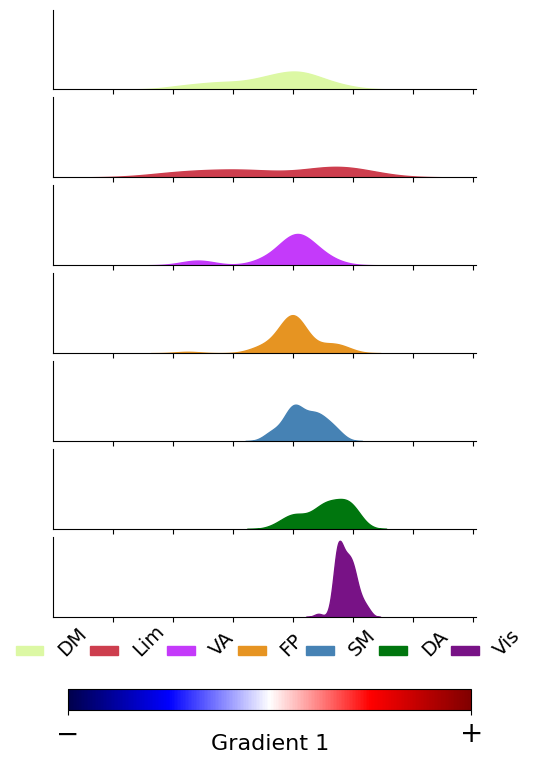

In [44]:
g = sns.FacetGrid(sorted_diffG1_melt, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.kdeplot,"Gradients", fill=True, alpha=1)

hue_labels = ['DM','Lim','VA','FP','SM','DA','Vis']
g.add_legend(labels=hue_labels)
sns.move_legend(
    g, "center",
    bbox_to_anchor=(0.5, 0.05), ncol=7, title=None, borderaxespad=0,
    columnspacing=0
)
for text in g.legend.texts:
    text.set_fontsize(14)
    text.set_rotation(45)
g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.1)

norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = g.fig.add_axes([0.15, -.05, 0.7, 0.03]) # start x, start y, length x, height y
cb = g.fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                    ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=20)

g.savefig(fig_path+f'Diff_G1-weighted_cortical_networks_Facet-kdes_Mean-sorted_blabel.png', dpi=300, bbox_inches='tight')

##### HistPlot

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-p

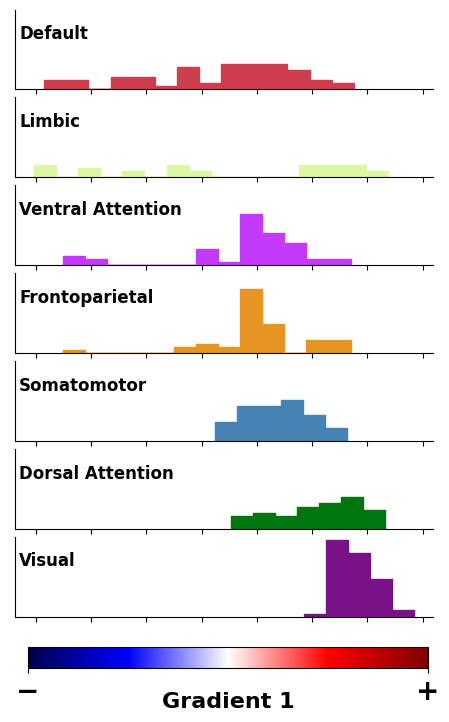

In [34]:
g = sns.FacetGrid(sorted_diffG1_melt, row="Networks", hue="Networks", aspect=5, height=1, palette=yeo_cols)
g.map(sns.histplot,"Gradients", element="step", fill=True, alpha=1, common_bins=True, binwidth=0.02)
g.set(ylim=(0, 25))

def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .7, label, fontweight="bold",
            ha="left", va="center", fontsize=12, transform=ax.transAxes)
g.map(label, "Gradients")

g.set_titles("")
g.set(yticklabels=[], yticks=[], ylabel="", xlabel="", xticklabels=[])
g.figure.subplots_adjust(hspace=0.1)

norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = g.fig.add_axes([0.15, 0.01, 0.8, 0.03]) # start x, start y, length x, height y
cb = g.fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                    ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10, fontweight="bold")
cb.ax.set_xticklabels(['−','+'], fontsize=20, fontweight="bold")

g.savefig(fig_path+f'Diff_G1-weighted_cortical_networks_Facet-hist-step_Mean-sorted_color-corrected.png', dpi=300, bbox_inches='tight')

### Statistical test (permutation test)

#### calculate null maps

In [47]:
# get the cortical data
Func_GCtx = np.load(Func_results + 'Func_Gradient-weighted_CorticalConnectivity.npz')
func_g1 = pd.DataFrame(Func_GCtx['G1_Ctx'])
func_g2 = pd.DataFrame(Func_GCtx['G2_Ctx'])

In [48]:
Diff_GCtx = np.load(Diff_results + 'Diff_Gradient-weighted_CorticalConnectivity.npz')
diff_g1 = pd.DataFrame(Diff_GCtx['G1_Ctx'])
diff_g2 = pd.DataFrame(Diff_GCtx['G2_Ctx'])

In [49]:
func_g1_ctx = np.nanmean(func_g1.to_numpy(),axis=0).reshape([360])
func_g2_ctx = np.nanmean(func_g2.to_numpy(),axis=0).reshape([360])

In [50]:
diff_g1_ctx = np.nanmean(diff_g1.to_numpy(),axis=0).reshape([360])
diff_g2_ctx = np.nanmean(diff_g2.to_numpy(),axis=0).reshape([360])

In [52]:
# preparing parcellation for null maps calculation
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

In [53]:
from neuromaps import parcellate
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [54]:
n_perm = 1000 #specify number of permutation

In [55]:
from neuromaps import nulls
func_g1_rotated = nulls.alexander_bloch(func_g1_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [56]:
func_g2_rotated = nulls.alexander_bloch(func_g2_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [57]:
diff_g1_rotated = nulls.alexander_bloch(diff_g1_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [58]:
diff_g2_rotated = nulls.alexander_bloch(diff_g2_ctx, atlas='fsaverage', density='10k',
                                        n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [59]:
pd.DataFrame(func_g1_rotated).to_csv(results_path + f'Func_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [60]:
pd.DataFrame(func_g2_rotated).to_csv(results_path + f'Func_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [61]:
pd.DataFrame(diff_g1_rotated).to_csv(results_path + f'Diff_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [62]:
pd.DataFrame(diff_g2_rotated).to_csv(results_path + f'Diff_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv', index = False)

In [63]:
func_g1_rotated = pd.read_csv(results_path + f'Func_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()
func_g2_rotated = pd.read_csv(results_path + f'Func_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()

In [64]:
diff_g1_rotated = pd.read_csv(results_path + f'Diff_G1_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()
diff_g2_rotated = pd.read_csv(results_path + f'Diff_G2_alex-rotated_N-perm'+str(n_perm)+'_data.csv').to_numpy()

#### repeat network the ANOVA for rotated data

In [65]:
# getting network data
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [66]:
n_times = np.arange(0, n_perm, 1)

In [67]:
fG1N_net = {}
for i in n_times:
    fG1N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = func_g1_rotated[:,i].T[net_inds]
        fG1N_net[i][str(nets)] = pd.Series(net_con)

In [68]:
fG2N_net = {}
for i in n_times:
    fG2N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = func_g2_rotated[:,i].T[net_inds]
        fG2N_net[i][str(nets)] = pd.Series(net_con)

In [69]:
sG1N_net = {}
for i in n_times:
    sG1N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = diff_g1_rotated[:,i].T[net_inds]
        sG1N_net[i][str(nets)] = pd.Series(net_con)

In [70]:
sG2N_net = {}
for i in n_times:
    sG2N_net[i] = pd.DataFrame()
    for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con = diff_g2_rotated[:,i].T[net_inds]
        sG2N_net[i][str(nets)] = pd.Series(net_con)

In [71]:
fG1N_melt_net = {}
for i in n_times:
    fG1N_melt_net[i] = pd.melt(fG1N_net[i], var_name='Networks', value_name='Gradients')

In [72]:
fG2N_melt_net = {}
for i in n_times:
    fG2N_melt_net[i] = pd.melt(fG2N_net[i], var_name='Networks', value_name='Gradients')

In [73]:
sG1N_melt_net = {}
for i in n_times:
    sG1N_melt_net[i] = pd.melt(sG1N_net[i], var_name='Networks', value_name='Gradients')

In [74]:
sG2N_melt_net = {}
for i in n_times:
    sG2N_melt_net[i] = pd.melt(sG2N_net[i], var_name='Networks', value_name='Gradients')

In [75]:
aov = {}
funcG1_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=fG1N_melt_net[i], dv='Gradients', between='Networks')
    funcG1_Naov = pd.concat([funcG1_Naov, aov[i]], names=i)

In [76]:
aov = {}
funcG2_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=fG2N_melt_net[i], dv='Gradients', between='Networks')
    funcG2_Naov = pd.concat([funcG2_Naov, aov[i]], names=i)

In [77]:
aov = {}
diffG1_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=sG1N_melt_net[i], dv='Gradients', between='Networks')
    diffG1_Naov = pd.concat([diffG1_Naov, aov[i]], names=i)

In [78]:
aov = {}
diffG2_Naov = pd.DataFrame(columns = ['Source', 'ddof1', 'ddof2', 'F', 'p-unc', 'np2'], dtype='object')
for i in n_times:
    aov[i] = pg.anova(data=sG2N_melt_net[i], dv='Gradients', between='Networks')
    diffG2_Naov = pd.concat([diffG2_Naov, aov[i]], names=i)

#### calculate empirical and p_perm

In [79]:
funcG1_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = func_g1_ctx[net_inds]
    funcG1_emp[str(nets)] = pd.Series(net_con)

In [80]:
funcG2_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = func_g2_ctx[net_inds]
    funcG2_emp[str(nets)] = pd.Series(net_con)

In [81]:
diffG1_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = diff_g1_ctx[net_inds]
    diffG1_emp[str(nets)] = pd.Series(net_con)

In [82]:
diffG2_emp = pd.DataFrame()
for nets in networks:
    net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
    net_inds = list(net_df.index.values)
    net_con = diff_g2_ctx[net_inds]
    diffG2_emp[str(nets)] = pd.Series(net_con)

In [83]:
funcG1_meltemp = pd.melt(funcG1_emp, var_name='Networks', value_name='Gradients')
funcG1_empaov = pg.anova(data=funcG1_meltemp, dv='Gradients', between='Networks')

In [84]:
funcG2_meltemp = pd.melt(funcG2_emp, var_name='Networks', value_name='Gradients')
funcG2_empaov = pg.anova(data=funcG2_meltemp, dv='Gradients', between='Networks')

In [85]:
diffG1_meltemp = pd.melt(diffG1_emp, var_name='Networks', value_name='Gradients')
diffG1_empaov = pg.anova(data=diffG1_meltemp, dv='Gradients', between='Networks')

In [86]:
diffG2_meltemp = pd.melt(diffG2_emp, var_name='Networks', value_name='Gradients')
diffG2_empaov = pg.anova(data=diffG2_meltemp, dv='Gradients', between='Networks')

In [87]:
funcG1_emp = funcG1_empaov['F'].values
funcG1_null = funcG1_Naov['F'].values

In [88]:
funcG2_emp = funcG2_empaov['F'].values
funcG2_null = funcG2_Naov['F'].values

In [89]:
diffG1_emp = diffG1_empaov['F'].values
diffG1_null = diffG1_Naov['F'].values

In [90]:
diffG2_emp = diffG2_empaov['F'].values
diffG2_null = diffG2_Naov['F'].values

In [91]:
funcG1_pperm = (np.sum(funcG1_null > funcG1_emp).astype(int)) / n_perm
funcG1_pperm

0.0

In [92]:
funcG2_pperm = (np.sum(funcG2_null > funcG2_emp).astype(int)) / n_perm
funcG2_pperm

0.0

In [93]:
diffG1_pperm = (np.sum(diffG1_null > diffG1_emp).astype(int)) / n_perm
diffG1_pperm

0.046

In [94]:
diffG2_pperm = (np.sum(diffG2_null > diffG2_emp).astype(int)) / n_perm
diffG2_pperm

0.045

#### calculate pairwise stats

In [95]:
funcG1_posthoc = pg.pairwise_tukey(data=funcG1_meltemp, dv='Gradients', between='Networks')
funcG2_posthoc = pg.pairwise_tukey(data=funcG2_meltemp, dv='Gradients', between='Networks')

In [96]:
diffG1_posthoc = pg.pairwise_tukey(data=diffG1_meltemp, dv='Gradients', between='Networks')
diffG2_posthoc = pg.pairwise_tukey(data=diffG2_meltemp, dv='Gradients', between='Networks')

In [97]:
funcG1_pperm=0.001
funcG2_pperm=0.001
funcG1_posthoc_pperm = funcG1_posthoc[funcG1_posthoc['p-tukey'].values < funcG1_pperm]
funcG2_posthoc_pperm = funcG2_posthoc[funcG2_posthoc['p-tukey'].values < funcG2_pperm]

In [98]:
diffG1_posthoc_pperm = diffG1_posthoc[diffG1_posthoc['p-tukey'].values < diffG1_pperm]
diffG2_posthoc_pperm = diffG2_posthoc[diffG2_posthoc['p-tukey'].values < diffG2_pperm]

#### print anova and pairwise stat

In [99]:
pg.print_table(funcG1_empaov, floatfmt='.6f')


ANOVA SUMMARY

Source      ddof1    ddof2          F     p-unc       np2
--------  -------  -------  ---------  --------  --------
Networks        6      330  88.205304  0.000000  0.615936



In [100]:
pg.print_table(funcG1_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                  B                    mean(A)    mean(B)       diff        se           T    p-tukey     hedges
-----------------  -----------------  ---------  ---------  ---------  --------  ----------  ---------  ---------
Default            Dorsal Attention   -0.011302   0.014709  -0.026011  0.001648  -15.778493   0.000000  -2.872540
Default            Frontoparietal     -0.011302   0.007854  -0.019156  0.001638  -11.695085   0.000000  -1.783574
Default            Limbic             -0.011302  -0.003255  -0.008046  0.001877   -4.287009   0.000472  -0.734834
Default            Somatomotor        -0.011302   0.006963  -0.018264  0.001566  -11.661080   0.000000  -2.034054
Default            Ventral Attention  -0.011302   0.022147  -0.033448  0.001609  -20.792662   0.000000  -3.561663
Default            Visual             -0.011302   0.005031  -0.016333  0.001524  -10.718931   0.000000  -1.752203
Dorsal Attention   Limbic              0.014709  -0.003255   0.017964  

In [101]:
pg.print_table(funcG2_empaov, floatfmt='.6f')


ANOVA SUMMARY

Source      ddof1    ddof2          F     p-unc       np2
--------  -------  -------  ---------  --------  --------
Networks        6      330  32.830638  0.000000  0.373795



In [102]:
pg.print_table(funcG2_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                 B                    mean(A)    mean(B)       diff        se           T    p-tukey     hedges
----------------  -----------------  ---------  ---------  ---------  --------  ----------  ---------  ---------
Default           Dorsal Attention    0.000023  -0.000887   0.000911  0.000183    4.989825   0.000020   0.801667
Default           Frontoparietal      0.000023  -0.001811   0.001835  0.000181   10.118039   0.000000   1.589997
Default           Limbic              0.000023  -0.000993   0.001016  0.000208    4.890752   0.000032   0.746982
Dorsal Attention  Frontoparietal     -0.000887  -0.001811   0.000924  0.000194    4.757339   0.000060   1.295956
Dorsal Attention  Somatomotor        -0.000887   0.000543  -0.001430  0.000187   -7.654334   0.000000  -2.288755
Frontoparietal    Somatomotor        -0.001811   0.000543  -0.002355  0.000186  -12.676970   0.000000  -3.533854
Frontoparietal    Ventral Attention  -0.001811  -0.000639  -0.001172  0.000190 

In [103]:
pg.print_table(diffG1_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                  B                    mean(A)    mean(B)       diff        se           T    p-tukey     hedges
-----------------  -----------------  ---------  ---------  ---------  --------  ----------  ---------  ---------
Default            Dorsal Attention   -0.033827   0.054464  -0.088290  0.010940   -8.070254   0.000000  -1.461780
Default            Frontoparietal     -0.033827   0.002555  -0.036381  0.010870   -3.346834   0.015756  -0.586263
Default            Somatomotor        -0.033827   0.019055  -0.052881  0.010395   -5.087440   0.000013  -0.930648
Default            Visual             -0.033827   0.087829  -0.121656  0.010112  -12.030511   0.000000  -2.315403
Dorsal Attention   Frontoparietal      0.054464   0.002555   0.051909  0.011645    4.457803   0.000228   1.254647
Dorsal Attention   Limbic              0.054464  -0.027575   0.082038  0.013137    6.244855   0.000000   1.093448
Dorsal Attention   Somatomotor         0.054464   0.019055   0.035409  

In [104]:
pg.print_table(diffG2_posthoc_pperm, floatfmt='.6f')


POST HOC TESTS

A                  B                    mean(A)    mean(B)       diff        se          T    p-tukey     hedges
-----------------  -----------------  ---------  ---------  ---------  --------  ---------  ---------  ---------
Default            Dorsal Attention    0.004262  -0.005595   0.009857  0.002053   4.800350   0.000049   1.031639
Default            Frontoparietal      0.004262  -0.003131   0.007393  0.002040   3.623451   0.006154   0.698871
Default            Limbic              0.004262  -0.026663   0.030926  0.002338  13.227475   0.000000   2.258692
Default            Somatomotor         0.004262  -0.005319   0.009581  0.001951   4.910867   0.000029   0.982481
Default            Ventral Attention   0.004262  -0.005588   0.009850  0.002004   4.915412   0.000029   0.758423
Default            Visual              0.004262  -0.012711   0.016974  0.001898   8.942539   0.000000   1.774520
Dorsal Attention   Limbic             -0.005595  -0.026663   0.021068  0.002466